**Belligol** **Predictor**

**Cargar y Preparar Datos**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo .csv
csv_path = 'LaLiga_Matches_respaldo.csv'  # Asegúrate de proporcionar la ruta correcta al archivo
la_liga_data = pd.read_csv(csv_path)
la_liga_data['Date'] = pd.to_datetime(la_liga_data['Date'], format='%d-%m-%Y')

# Verificar los datos cargados
print(la_liga_data.head())

# Función para convertir resultados a valores numéricos
def convertir_resultados(result):
    if result == 'H':
        return 1
    elif result == 'A':
        return -1
    else:
        return 0

# Crear características adicionales
def crear_caracteristicas(df):
    df['FTR_numeric'] = df['FTR'].apply(convertir_resultados)
    df['GoalDifference'] = df['FTHG'] - df['FTAG']
    df['HomeForm'] = df.groupby('HomeTeam')['FTR_numeric'].rolling(5).sum().reset_index(0, drop=True)
    df['AwayForm'] = df.groupby('AwayTeam')['FTR_numeric'].rolling(5).sum().reset_index(0, drop=True)
    df['HomeGoalsLast5'] = df.groupby('HomeTeam')['FTHG'].rolling(5).mean().reset_index(0, drop=True)
    df['AwayGoalsLast5'] = df.groupby('AwayTeam')['FTAG'].rolling(5).mean().reset_index(0, drop=True)
    df['HomeConcededLast5'] = df.groupby('HomeTeam')['FTAG'].rolling(5).mean().reset_index(0, drop=True)
    df['AwayConcededLast5'] = df.groupby('AwayTeam')['FTHG'].rolling(5).mean().reset_index(0, drop=True)
    df.fillna(0, inplace=True)
    return df

# Crear las características en los datos
la_liga_data = crear_caracteristicas(la_liga_data)

# Seleccionar características para el modelo
features = ['HomeForm', 'AwayForm', 'HomeGoalsLast5', 'AwayGoalsLast5', 'HomeConcededLast5', 'AwayConcededLast5']
X = la_liga_data[features]
y = la_liga_data['FTR_numeric']

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


    Season       Date    HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR
0  1995-96 1995-09-02   La Coruna    Valencia     3     0   H   2.0   0.0   H
1  1995-96 1995-09-02    Sp Gijon    Albacete     3     0   H   3.0   0.0   H
2  1995-96 1995-09-03  Ath Bilbao   Santander     4     0   H   2.0   0.0   H
3  1995-96 1995-09-03  Ath Madrid    Sociedad     4     1   H   1.0   1.0   D
4  1995-96 1995-09-03       Celta  Compostela     0     1   A   0.0   0.0   D


Análisis Exploratorio de Datos
python

                                Date          FTHG          FTAG  \
count                          10883  10883.000000  10883.000000   
mean   2009-06-12 10:58:08.523385088      1.553340      1.116971   
min              1995-09-02 00:00:00      0.000000      0.000000   
25%              2002-03-03 00:00:00      1.000000      0.000000   
50%              2009-05-03 00:00:00      1.000000      1.000000   
75%              2016-08-28 00:00:00      2.000000      2.000000   
max              2023-10-02 00:00:00     10.000000      8.000000   
std                              NaN      1.303854      1.114065   

               HTHG          HTAG   FTR_numeric  GoalDifference      HomeForm  \
count  10883.000000  10883.000000  10883.000000    10883.000000  10883.000000   
mean       0.687586      0.484701      0.202701        0.436369      1.013599   
min        0.000000      0.000000     -1.000000       -8.000000     -5.000000   
25%        0.000000      0.000000     -1.000000       -1.000000

<ipython-input-46-5c49101d86cc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FTR', data=la_liga_data, palette='viridis')


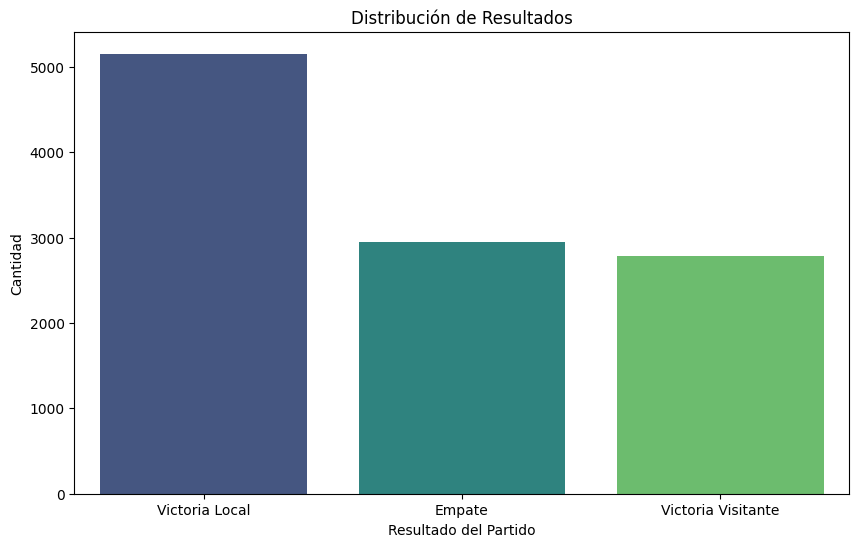

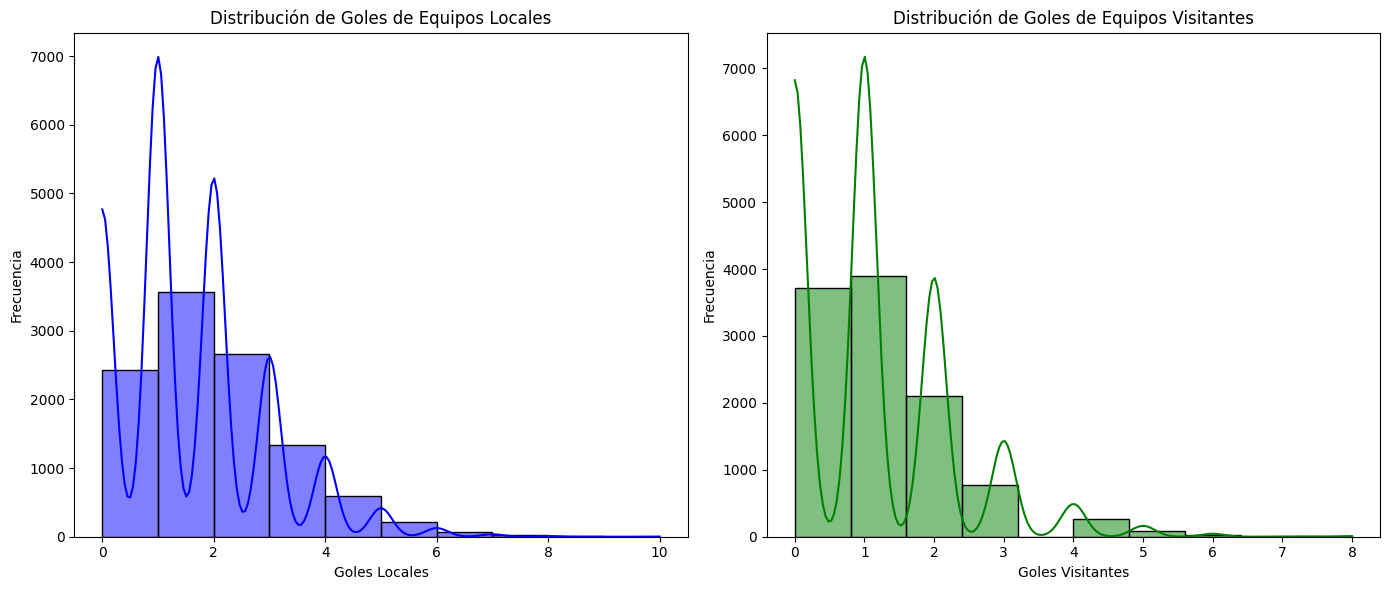

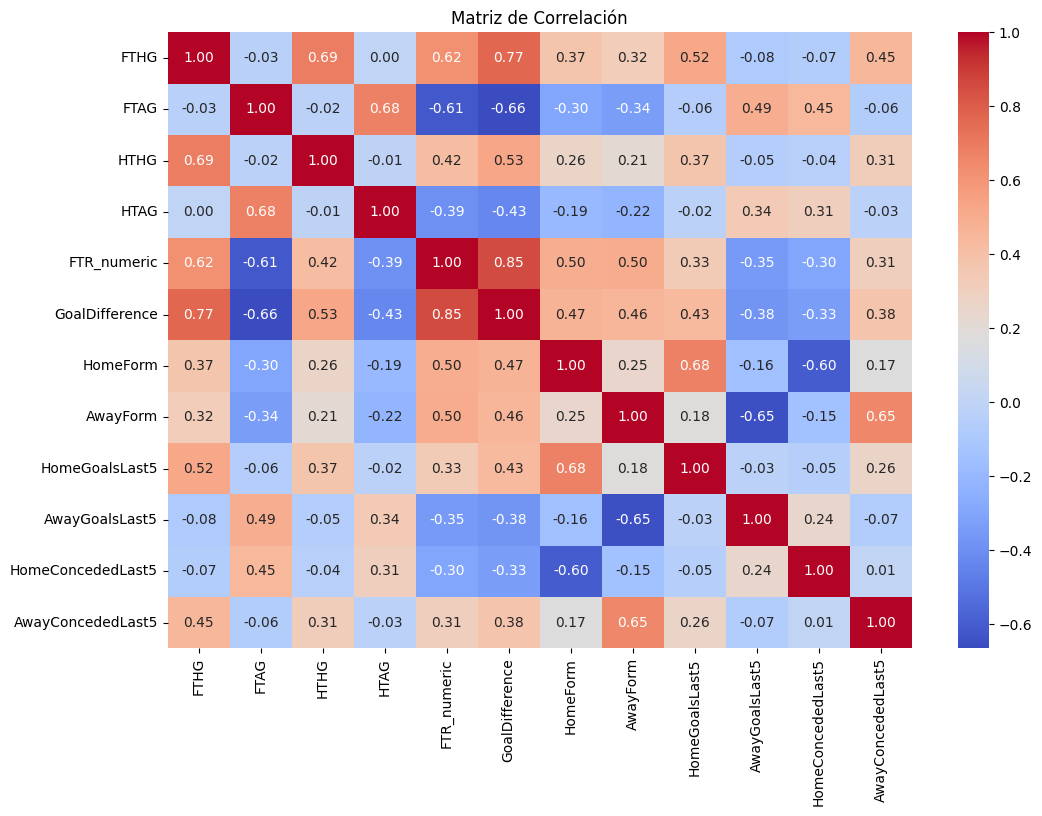

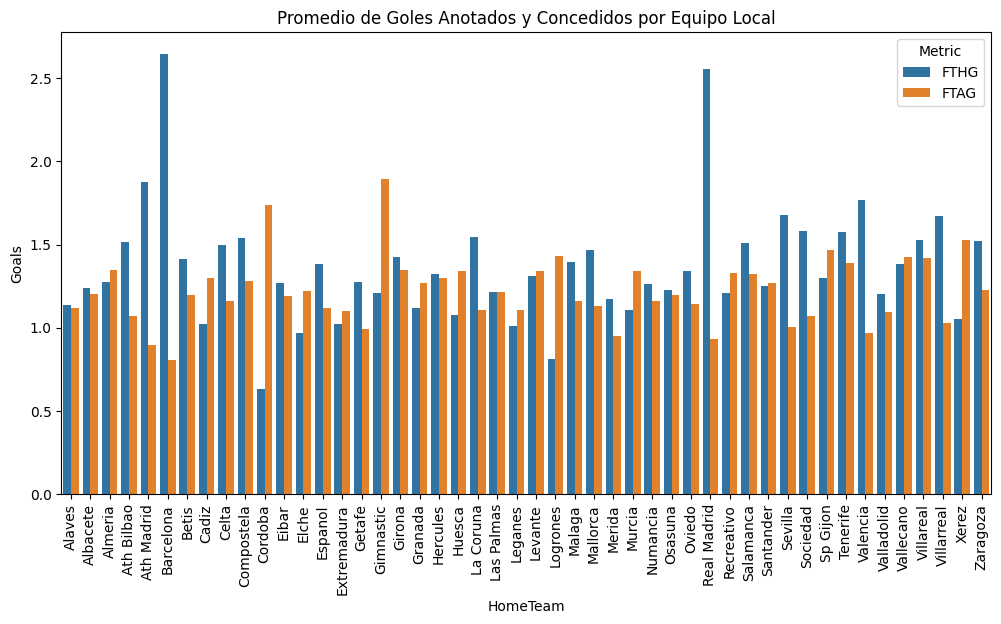

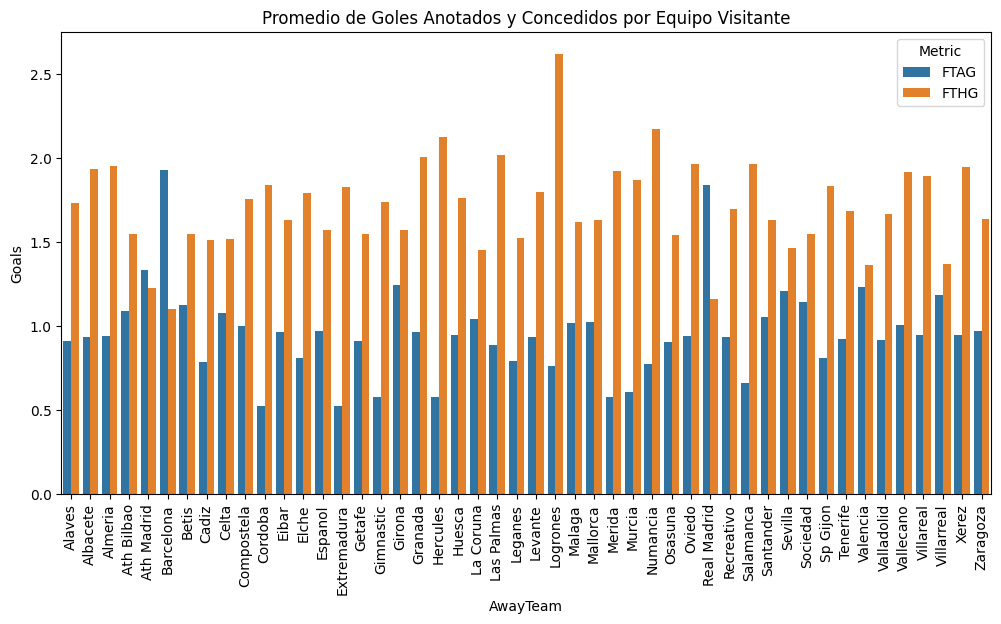

In [ ]:
# Mostrar algunas estadísticas descriptivas de los datos
print(la_liga_data.describe())

# Distribución de resultados
plt.figure(figsize=(10, 6))
sns.countplot(x='FTR', data=la_liga_data, palette='viridis')
plt.title('Distribución de Resultados')
plt.xlabel('Resultado del Partido')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1, 2], labels=['Victoria Local', 'Empate', 'Victoria Visitante'])
plt.show()

# Distribución de goles
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(la_liga_data['FTHG'], bins=10, kde=True, color='blue')
plt.title('Distribución de Goles de Equipos Locales')
plt.xlabel('Goles Locales')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(la_liga_data['FTAG'], bins=10, kde=True, color='green')
plt.title('Distribución de Goles de Equipos Visitantes')
plt.xlabel('Goles Visitantes')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Matriz de correlación solo con columnas numéricas
columnas_numericas = la_liga_data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(columnas_numericas.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


# Promedio de goles anotados y concedidos por equipo local
home_stats = la_liga_data.groupby('HomeTeam')[['FTHG', 'FTAG']].mean().reset_index()
home_stats = home_stats.melt(id_vars='HomeTeam', var_name='Metric', value_name='Goals')
plt.figure(figsize=(12, 6))
sns.barplot(x='HomeTeam', y='Goals', hue='Metric', data=home_stats)
plt.xticks(rotation=90)
plt.title('Promedio de Goles Anotados y Concedidos por Equipo Local')
plt.show()

# Promedio de goles anotados y concedidos por equipo visitante
away_stats = la_liga_data.groupby('AwayTeam')[['FTAG', 'FTHG']].mean().reset_index()
away_stats = away_stats.melt(id_vars='AwayTeam', var_name='Metric', value_name='Goals')
plt.figure(figsize=(12, 6))
sns.barplot(x='AwayTeam', y='Goals', hue='Metric', data=away_stats)
plt.xticks(rotation=90)
plt.title('Promedio de Goles Anotados y Concedidos por Equipo Visitante')
plt.show()

Modelado

In [ ]:
# Implementar validación cruzada
scores = cross_val_score(SVC(probability=True), X_train_scaled, y_train, cv=5)

print("Precisión promedio con validación cruzada:", scores.mean())
print("Desviación estándar de la precisión:", scores.std())

# Entrenar el modelo SVM
modelo_svm = SVC(probability=True)
modelo_svm.fit(X_train_scaled, y_train)

# Calcular la precisión del modelo
y_pred = modelo_svm.predict(X_test_scaled)
print("Precisión del modelo:", accuracy_score(y_test, y_pred))

# Evaluar el modelo
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Precisión promedio con validación cruzada: 0.6237079525273821
Desviación estándar de la precisión: 0.006682608824871583
Precisión del modelo: 0.6361966008268259
              precision    recall  f1-score   support

          -1       0.63      0.68      0.66       590
           0       0.46      0.13      0.20       556
           1       0.66      0.88      0.75      1031

    accuracy                           0.64      2177
   macro avg       0.58      0.57      0.54      2177
weighted avg       0.60      0.64      0.59      2177

[[404  43 143]
 [158  73 325]
 [ 81  42 908]]


Predicción Partido específico

In [ ]:
# Ejemplo de predicción para un partido específico
equipo_local = 'Barcelona'
equipo_visitante = 'Las Palmas'

# Obtener estadísticas para los equipos
stats_local = la_liga_data[la_liga_data['HomeTeam'] == equipo_local].tail(1)
stats_visitante = la_liga_data[la_liga_data['AwayTeam'] == equipo_visitante].tail(1)

# Crear un DataFrame con las estadísticas del partido específico
datos_partido = {
    'HomeForm': stats_local['HomeForm'].values,
    'AwayForm': stats_visitante['AwayForm'].values,
    'HomeGoalsLast5': stats_local['HomeGoalsLast5'].values,
    'AwayGoalsLast5': stats_visitante['AwayGoalsLast5'].values,
    'HomeConcededLast5': stats_local['HomeConcededLast5'].values,
    'AwayConcededLast5': stats_visitante['AwayConcededLast5'].values
}

datos_partido_df = pd.DataFrame(datos_partido)

# Normalizar los datos del partido específico
datos_partido_scaled = scaler.transform(datos_partido_df)

# Usar el modelo entrenado para obtener las probabilidades
probabilidades = modelo_svm.predict_proba(datos_partido_scaled)

# Mostrar las probabilidades de cada resultado
print("Probabilidades de Resultado para", equipo_local, "vs", equipo_visitante, ":")
print("Victoria Local (H):", probabilidades[0][2])
print("Empate (D):", probabilidades[0][1])
print("Victoria Visitante (A):", probabilidades[0][0])



Probabilidades de Resultado para Barcelona vs Las Palmas :
Victoria Local (H): 0.7177870338855533
Empate (D): 0.20487682867790183
Victoria Visitante (A): 0.07733613743654487
